# Functions

## EDA Plot Functions

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def univariate_analysis_numerical(df, column_name):
    # Check if the column is numerical
    if df[column_name].dtype in ['int64', 'float64']:
        # Plot histogram
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        sns.histplot(df[column_name], kde=True)
        plt.title('Histogram')

        # Plot boxplot
        plt.subplot(1, 3, 2)
        plt.boxplot(df[column_name],patch_artist=True, notch=True)
        # Detect those values that are extreme outliers, more than 3 times the IQR
        Q1 = df[column_name].quantile(0.25)
        Q3 = df[column_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        # Add one to the column named ext_univar_outlier
        outliers = (df[column_name] < lower_bound) | (df[column_name] > upper_bound)
        df.loc[outliers, 'ext_univar_outlier'] += 1

        # check if any outliers are over the upper bound
        if df[column_name].max() > upper_bound:
            plt.axhline(y=upper_bound, color='r', linestyle='--', linewidth=1)
        if df[column_name].min() < lower_bound:
            plt.axhline(y=lower_bound, color='r', linestyle='--', linewidth=1)


        plt.show()
        return df

    else:
        print("The specified column is not numerical.")
        return df
    
def univariate_analysis_categorical(df, column_name):
    # Check if the column is categorical
    if df[column_name].dtype == 'object':
        # Plot bar chart
        if column_name == 'differentiate':
            # change the names
            df[column_name] = df[column_name].replace({"Well differentiated": 'well diff', "Moderately differentiated": 'mod diff', 
                                                       "Poorly differentiated": 'poor diff', "Undifferentiated": 'undiff'})
            # plot the graph following the order
            plt.figure()
            sns.countplot(x=df[column_name], order=['well diff', 'mod diff', 'poor diff', 'undiff'])
            plt.title('Bar Chart')
            print(df[column_name].value_counts())

        elif column_name == '6th Stage':
            plt.figure()
            sns.countplot(x=df[column_name], order=['IIA','IIB','IIIA','IIIB','IIIC'])
            plt.title('Bar Chart')
            print(df[column_name].value_counts())
            
        else:
            plt.figure()
            sns.countplot(x=df[column_name])
            plt.title('Bar Chart')
            # print the number of samples in each category
            print(df[column_name].value_counts())
       

    else:
        print("The specified column is not categorical.")

def bivariate_numerical(df):
    target_variable = 'Status'
    num_vars = df.select_dtypes(include=['int64', 'float64']).columns
    
    sns.pairplot(df[num_vars], hue='Status')
    
    df_melted = df.melt(id_vars=target_variable, value_vars=num_vars)

    # Create a box plot categorized by the categorical variable on the y-axis
    sns.catplot(x='variable', y='value', hue=target_variable, kind='box', data=df_melted, height=6, aspect=2)

    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

def bivariate_categorical(df):
    target_variable = 'Status'
    cat_vars = df.select_dtypes(include=['object']).columns
    
    # drop status
    cat_vars = cat_vars.drop('Status')
    
    num_plots = len(cat_vars)
    num_cols = 3  # Number of columns in the subplot grid
    num_rows = (num_plots - 1) // num_cols + 1
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    axes = axes.flatten()
    
    for i, cat_var in enumerate(cat_vars):
        if cat_var == '6th Stage':
            cat_var_positive = df[df[target_variable] == 'Alive'][cat_var].value_counts(normalize=True)
            cat_var_negative = df[df[target_variable] == 'Dead'][cat_var].value_counts(normalize=True)
            classes = ['IIA', 'IIB', 'IIIA', 'IIIB', 'IIIC']
        else:
            if cat_var == 'differentiate':
                df[cat_var] = df[cat_var].replace({"Well differentiated": 'well diff', "Moderately differentiated": 'mod diff', 
                                               "Poorly differentiated": 'poor diff', "Undifferentiated": 'undiff'})
        
            # Calculate proportions for each category ensuring the sum is 100%
            cat_var_positive = df[df[target_variable] == 'Alive'][cat_var].value_counts(normalize=True) * 100
            cat_var_negative = df[df[target_variable] == 'Dead'][cat_var].value_counts(normalize=True) * 100
            cat_var_positive /= cat_var_positive.sum() / 100
            cat_var_negative /= cat_var_negative.sum() / 100
            classes = pd.Series(df[cat_var].unique())
        
        ax = axes[i]
        index = np.arange(len(classes))
        width = 0.35
        ax.bar(index, cat_var_positive, width, label='Alive')
        ax.bar(index + width, cat_var_negative, width, label='Dead')
        ax.set_xlabel(cat_var)
        ax.set_ylabel('Percentage')
        ax.set_title(f'{cat_var} vs {target_variable}')
        ax.set_xticks(index + width / 2)
        ax.set_xticklabels(classes)
        ax.legend()

    # Hide empty subplots
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def join_barcharts(data1, data2, labels, title='', xlabel='', ylabel='', legend_labels=('Positive', 'Negative')):
    
    n = len(labels)
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(nrows=3, ncols=3)
    index = np.arange(n)
    rects1 = ax.bar(index, data1, width, label=legend_labels[0])
    rects2 = ax.bar(index + width, data2, width, label=legend_labels[1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(index + width / 2)
    ax.set_xticklabels(labels)
    ax.legend()

    return fig, ax
    


## PCA Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



def cumulative_explained_variance_plot(X):
    pca = PCA()
    pca.fit(X)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = explained_variance_ratio.cumsum()
    print(cumulative_variance)
    # Plot histogram
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(cumulative_variance) + 1), cumulative_variance, alpha=0.6)
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance Ratio by Number of Principal Components')
    plt.grid(True)
    plt.show()

def pca_plot(X):
    status = X['Status']
    X = X.drop(columns=['Status'])
    pca = PCA()
    X_pca = pca.fit_transform(X)
    X_pca_positive = X_pca[status == 1] # Alive
    X_pca_negative = X_pca[status == 0] # Dead
    # Get the principal components
    components = pca.components_

    # Plot original features as vectors in PCA space
    plt.figure(figsize=(16, 12))
    plt.scatter(X_pca_positive[:, 0], X_pca_positive[:, 1], color='b', alpha=0.6, label='Alive')
    plt.scatter(X_pca_negative[:, 0], X_pca_negative[:, 1], color='r', alpha=0.6, label='Dead')

    features = ['Age','T Stage','N Stage','6th Stage','differentiate','A Stage','Tumor Size',
                'Estrogen Status','Progesterone Status','Regional Node Examined','Regional Node Positive',
                'Survival Months','Status']
    # list of 13 colors
    colors = ['b', 'g', 'pink', 'c', 'm', 'y', 'k', 'gray', 'orange', 'purple', 'brown', 'r']
    # Plot vectors representing original features
    for i, (pc1, pc2) in enumerate(zip(components[0], components[1])):
        plt.arrow(0, 0, pc1*30, pc2*30, color=colors[i], alpha=1, width=0.05, head_width=0.5, label=features[i])
        
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA with Original Features as Vectors')
    plt.legend()
    plt.grid(True)
    plt.show()


# Executing EDA plots

In [26]:
import pandas as pd
import os
#parent_directory = os.path.dirname(os.getcwd())
#os.chdir(parent_directory)
print(os.getcwd())
#EDA on numerical variables
# Load the dataset

df_breast_cancer = pd.read_csv('data/Breast_Cancer.csv', sep=",", header=0)
#univariate_analysis_categorical(df_breast_cancer, 'Status')
'''df_breast_cancer["ext_univar_outlier"] = 0

for column in df_breast_cancer.columns:
    if column not in ['ext_univar_outlier']:
        #df_breast_cancer = univariate_analysis_numerical(df_breast_cancer, column)
        univariate_analysis_categorical(df_breast_cancer, column)
df_breast_cancer.to_csv('data/Breast_Cancer_outliers.csv', index=False)'''
#bivariate_numerical(df_breast_cancer[['Age', 'Tumor Size', 'Regional Node Examined', 'Regional Node Positive','Survival Months','Status']])
#bivariate_categorical(df_breast_cancer)


c:\Users\JaIk194\Documents\Master\Q2\ML\Project\BreastCancerClassification
655


# Executing PCA plots

c:\Users\JaIk194\Documents\Master\Q2\ML\Project\BreastCancerClassification
[0.52217089 0.8658654  0.92749596 0.98214764 0.99872494 0.99922707
 0.99952201 0.99967796 0.99981137 0.99991512 0.99994992 0.99997955
 1.        ]


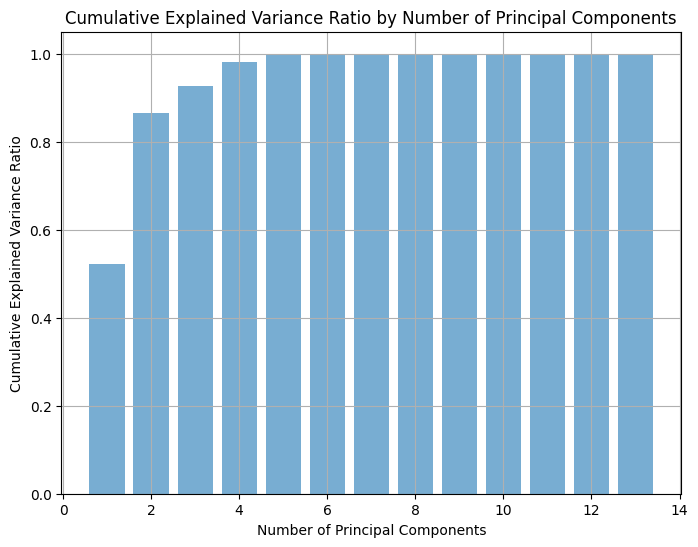

In [8]:
print(os.getcwd())
data = pd.read_csv('data/Breast_Cancer_Preprocessed.csv')

# Separate features (X) from labels if applicable
X = data.drop(columns=['Race', 'Marital Status'])
cumulative_explained_variance_plot(X)
#pca_plot(X)


In [ ]:
breast_cancer.shape

(4019, 16)

### Bivariate Analysis

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

def perform_chi_squared_test(data, categorical_columns):
    results = []
    
    # Perform chi-square test for each pair of categorical variables
    for i in range(len(categorical_columns)):
        for j in range(i+1, len(categorical_columns)):
            # Create contingency table for the pair of categorical variables
            contingency_table = pd.crosstab(data[categorical_columns[i]], data[categorical_columns[j]])
            
            # Perform chi-square test
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            
            # Append results to the list
            results.append({
                'Variable_1': categorical_columns[i],
                'Variable_2': categorical_columns[j],
                'Chi2_Statistic': chi2,
                'p-value': p,
            })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# List of categorical variables
cat_cols = ['race', 'marital_status', 't_stage', 'n_stage', '6th_stage', 'differentiate', 'a_stage', 'estrogen_status', 'progesterone_status', 'status']

# Perform chi-square test
chi_squared_results = perform_chi_squared_test(breast_cancer, cat_cols)

# Print results
print(chi_squared_results)





             Variable_1           Variable_2  Chi2_Statistic        p-value
0                  race       marital_status      137.649912   7.308896e-26
1                  race              t_stage        8.309501   2.162940e-01
2                  race              n_stage        6.215014   1.836560e-01
3                  race            6th_stage        8.923983   3.487492e-01
4                  race        differentiate       27.855377   1.000418e-04
5                  race              a_stage        0.303560   8.591773e-01
6                  race      estrogen_status       13.335971   1.270957e-03
7                  race  progesterone_status        4.982396   8.281072e-02
8                  race               status       27.992525   8.346424e-07
9        marital_status              t_stage       17.496399   1.318590e-01
10       marital_status              n_stage       22.713668   3.751987e-03
11       marital_status            6th_stage       28.533825   2.727577e-02
12       mar

In [ ]:
def filter_results_by_p_value(results_df, threshold=0.05):

    return results_df[results_df['p-value'] > threshold]

# Filter chi-square test results based on p-value threshold
filtered_results = filter_results_by_p_value(chi_squared_results)

# Print filtered results
print("Results with p-value > 0.05:")
print(filtered_results)


Results with p-value > 0.05:
        Variable_1           Variable_2  Chi2_Statistic   p-value
1             race              t_stage        8.309501  0.216294
2             race              n_stage        6.215014  0.183656
3             race            6th_stage        8.923983  0.348749
5             race              a_stage        0.303560  0.859177
7             race  progesterone_status        4.982396  0.082811
9   marital_status              t_stage       17.496399  0.131859
12  marital_status        differentiate       19.112768  0.085843
13  marital_status              a_stage        7.649645  0.105289
14  marital_status      estrogen_status        7.647599  0.105374
40         a_stage  progesterone_status        2.363510  0.124202


In [ ]:
# Filtrar resultados con p < 0.01
filtered_results = chi_squared_results[(chi_squared_results['p-value'] < 0.01)]

# Ordenar resultados por valor chi-cuadrado de mayor a menor
filtered_results = filtered_results.sort_values(by='Chi2_Statistic', ascending=False)

top_10_results = filtered_results.head(10)

# Imprimir los resultados filtrados
print("Results with p-value < 0.01 and sorted by Chi2_Statistic (from highest to lowest):")
print(top_10_results)


Results with p-value < 0.01 and sorted by Chi2_Statistic (from highest to lowest):
         Variable_1           Variable_2  Chi2_Statistic        p-value
18          t_stage            6th_stage     6758.500577   0.000000e+00
24          n_stage            6th_stage     6680.736947   0.000000e+00
42  estrogen_status  progesterone_status     1053.273598  4.729360e-231
31        6th_stage              a_stage      734.944227  9.446988e-158
20          t_stage              a_stage      588.843504  2.642004e-127
26          n_stage              a_stage      355.992419   4.979990e-78
17          t_stage              n_stage      321.169353   2.369998e-66
34        6th_stage               status      279.828664   2.426235e-59
29          n_stage               status      267.710959   7.367222e-59
36    differentiate      estrogen_status      217.262787   7.841574e-47


Multivariate Outliers Analysis

--- Number of Outliers ----
177


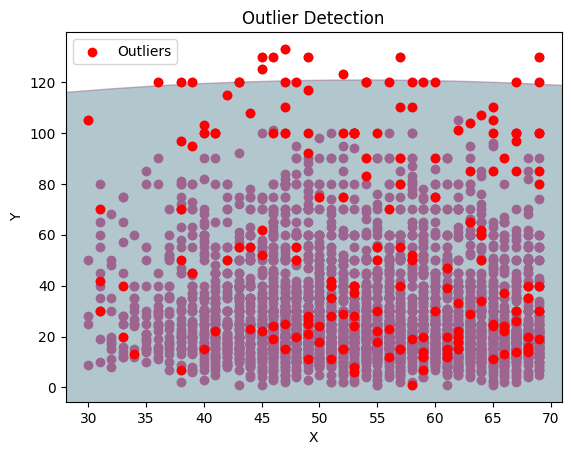

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import chi2

# Define your variables
df_mahalanobis = breast_cancer[num_cols]
df_mahalanobis = df_mahalanobis.to_numpy()

# Covariance matrix
cov_matrix = np.cov(df_mahalanobis, rowvar=False)
cov_matrix_pm1 = np.linalg.matrix_power(cov_matrix, -1)
centerpoint = np.mean(df_mahalanobis, axis=0)

# Distances between center point
distances = []
for val in df_mahalanobis:
    p1 = val
    p2 = centerpoint
    distance = (p1 - p2).T.dot(cov_matrix_pm1).dot(p1 - p2)
    distances.append(distance)
distances = np.array(distances)

# Cutoff (threshold) value from Chi-Sqaure Distribution for detecting outliers
cutoff = chi2.ppf(0.99, df_mahalanobis.shape[1])

# Index of outliers
outlierIndexes = np.where(distances > cutoff)

# Number of outliers
num_outliers = len(outlierIndexes[0])
print('--- Number of Outliers ----')
print(num_outliers)

# Extract outliers
df_multiv_outliers = df_mahalanobis[distances > cutoff, :]

# Finding ellipse dimensions
lambda_, v = np.linalg.eig(cov_matrix)
lambda_ = np.sqrt(lambda_)

# Ellipse patch
ellipse = patches.Ellipse(xy=(centerpoint[0], centerpoint[1]),
                          width=lambda_[0] * np.sqrt(cutoff) * 2, height=lambda_[1] * np.sqrt(cutoff) * 2,
                          angle=np.rad2deg(np.arccos(v[0, 0])), edgecolor='#9C648E')
ellipse.set_facecolor('#648E9C')  # Set the facecolor to '#9C648E'
ellipse.set_alpha(0.5)

# Scatter plot
fig, ax = plt.subplots()
ax.add_artist(ellipse)
ax.scatter(df_mahalanobis[:, 0], df_mahalanobis[:, 1], color='#9C648E')  # Set the scatter plot color to '#648E9C'

# Highlight outliers
ax.scatter(df_multiv_outliers[:, 0], df_multiv_outliers[:, 1], color='red', label='Outliers')

# Set plot title and labels
ax.set_title('Outlier Detection')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()

plt.show()
